In [3]:
import argparse

import torch
import numpy as np

from src.eval.eval import eval_single_dataset
from src.models.modeling import ImageEncoder

args = argparse.ArgumentParser()
args.model = "ViT-B-32"
args.batch_size = 32
args.device = "cuda"
args.save_dir = "temp"
args.data_location = "/mnt/lts4/scratch/data"
args.checkpoint_path = "/mnt/lts4/scratch/checkpoints/tall_mask_checkpoints/mount/model_checkpoints"

/conda/envs/ta/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
all_datasets = ["EuroSAT", "DTD", "SUN397", "MNIST", "RESISC45", "GTSRB", "Cars", "SVHN"]

# choose the target (fine-tuned) task here; the rest will be used as control tasks
target_dataset = "EuroSAT" 
control_datasets = all_datasets.copy()
control_datasets.remove(target_dataset)
all_datasets = [target_dataset] + control_datasets

print(f"Target dataset: {target_dataset}")
print(f"Control datasets: {control_datasets}")

Target dataset: EuroSAT
Control datasets: ['DTD', 'SUN397', 'MNIST', 'RESISC45', 'GTSRB', 'Cars', 'SVHN']


#### Load checkpoints and create task vector

In [5]:
ft_checkpoint = torch.load(f"{args.checkpoint_path}/ViT-B-32/{target_dataset}Val/nonlinear_finetuned.pt") # load the checkpoint finetuned on "StandfordCars" dataset
pt_checkpoint = torch.load(f"{args.checkpoint_path}/ViT-B-32/MNISTVal/nonlinear_zeroshot.pt") # load pre-trained model

task_vector = {k: ft_checkpoint[k] - pt_checkpoint[k] for k in ft_checkpoint.keys()} # compute the task vector

#### Evaluate the zero-shot accuracy of the pre-trained model

In [6]:
# load the pre-trained model
pt_image_encoder = ImageEncoder("ViT-B-32")
pt_image_encoder.load_state_dict(pt_checkpoint)

<All keys matched successfully>

In [7]:
# evaluate on all datasets
zeroshot_accuracies = {}

for dataset in all_datasets:
    zeroshot_accuracy = eval_single_dataset(pt_image_encoder, dataset, args)
    zeroshot_accuracies[dataset] = zeroshot_accuracy
    print("*"*100)
    print(f"Zero-shot accuracy on dataset {dataset}: {zeroshot_accuracy['top1']:.4f}")

Loading classification head for ViT-B-32 on EuroSATVal from temp/head_EuroSATVal.pt
Done evaluating on EuroSAT.	 Accuracy: 46.50%.	 Total time: 27.81s
****************************************************************************************************
Zero-shot accuracy on dataset EuroSAT: 0.4650
Loading classification head for ViT-B-32 on DTDVal from temp/head_DTDVal.pt
Done evaluating on DTD.	 Accuracy: 43.99%.	 Total time: 31.27s
****************************************************************************************************
Zero-shot accuracy on dataset DTD: 0.4399
Loading classification head for ViT-B-32 on SUN397Val from temp/head_SUN397Val.pt
Done evaluating on SUN397.	 Accuracy: 63.16%.	 Total time: 626.21s
****************************************************************************************************
Zero-shot accuracy on dataset SUN397: 0.6316
Loading classification head for ViT-B-32 on MNISTVal from temp/head_MNISTVal.pt
Done evaluating on MNIST.	 Accuracy: 48.26%.	

#### Evaluate the fine-tuned model on fine-tuned dataset and control datasets

In [8]:
# load the finetuned checkpoint
ft_image_encoder = ImageEncoder("ViT-B-32")
ft_image_encoder.load_state_dict(ft_checkpoint)

<All keys matched successfully>

In [9]:
ft_accuracies = {}

# evaluate on fine-tuned (target) dataset
ft_accuracies[target_dataset] = eval_single_dataset(ft_image_encoder, target_dataset, args)
print(f"Accuracy on target dataset {target_dataset}: {ft_accuracies[target_dataset]['top1']:.4f}, {ft_accuracies[target_dataset]['top1'] / zeroshot_accuracies['Cars']['top1'] * 100:.2f}% the performance compared to zero-shot")

# evaluate on control datasets
for control_dataset in control_datasets:
    ft_accuracies[control_dataset] = eval_single_dataset(ft_image_encoder, control_dataset, args)
    print("*"*100)
    print(f"Accuracy on control dataset {control_dataset}: {ft_accuracies[control_dataset]['top1']:.4f}, {ft_accuracies[control_dataset]['top1'] / zeroshot_accuracies[control_dataset]['top1'] * 100:.2f}% compared to zero-shot")

Loading classification head for ViT-B-32 on EuroSATVal from temp/head_EuroSATVal.pt
Done evaluating on EuroSAT.	 Accuracy: 99.87%.	 Total time: 10.79s
Accuracy on target dataset EuroSAT: 0.9987, 167.21% the performance compared to zero-shot
Loading classification head for ViT-B-32 on DTDVal from temp/head_DTDVal.pt
Done evaluating on DTD.	 Accuracy: 37.50%.	 Total time: 17.09s
****************************************************************************************************
Accuracy on control dataset DTD: 0.3750, 85.25% compared to zero-shot
Loading classification head for ViT-B-32 on SUN397Val from temp/head_SUN397Val.pt


#### Evaluate the fine-tuned model edited with LiNeS, on fine-tuned and control datasets

In [ ]:
def line_scaling(task_vector, alpha=0.0, beta=1.0, num_blocks=12):
    """
    Progressively scales the task vector based on layer depth.

    Parameters:
    -----------
    task_vector : dict
        A dictionary representing the residual between the fine-tuned checkpoint 
        and the pre-trained checkpoint. 
    alpha : float
         The minimum scaling factor for the blocks.
    beta : float
        The maximum scaling coefficient difference between the last and first block.
    num_blocks : int
        The total number of layer blocks in the model. 
    Returns:
    --------
    scaled_task_vector : dict
        A copy of `task_vector` where each key is scaled based on the layer depth.
    """
    
    import copy
    
    # Deep copy the task vector to avoid modifying the original
    scaled_task_vector = copy.deepcopy(task_vector)

    # Generate the key blocks corresponding to the layers of the model
    key_blocks = [f".resblocks.{i}." for i in range(num_blocks)]

    # Create a scaling dictionary to store the scaling factor for each key
    scaling_dic = {}
    for k in task_vector.keys():
        # Find the layer block in the key and assign scaling factor based on layer depth
        for layer, block in enumerate(key_blocks):
            if block in k:
                scaling_dic[k] = alpha + beta * (layer / (num_blocks - 1))
                break

    print(f"Scaling range for the layers: {alpha} to {alpha + beta}")

    # Scale the task vector based on the scaling dictionary
    scaled_task_vector = {
        # Use alpha if layer is outside residual blocks
        k: task_vector[k] * scaling_dic.get(k, alpha)  
        for k in task_vector.keys()
    }

    return scaled_task_vector

In [ ]:
scaled_task_vector = line_scaling(task_vector, alpha=0.1, beta=0.9, num_blocks=12)
ft_lines_checkpoint = {k: pt_checkpoint[k] + scaled_task_vector[k] for k in pt_checkpoint.keys()}

ft_lines_image_encoder = ImageEncoder("ViT-B-32")
ft_lines_image_encoder.load_state_dict(ft_lines_checkpoint)

Scaling dictionary: {'model.visual.transformer.resblocks.0.ln_1.weight': 0.1, 'model.visual.transformer.resblocks.0.ln_1.bias': 0.1, 'model.visual.transformer.resblocks.0.attn.in_proj_weight': 0.1, 'model.visual.transformer.resblocks.0.attn.in_proj_bias': 0.1, 'model.visual.transformer.resblocks.0.attn.out_proj.weight': 0.1, 'model.visual.transformer.resblocks.0.attn.out_proj.bias': 0.1, 'model.visual.transformer.resblocks.0.ln_2.weight': 0.1, 'model.visual.transformer.resblocks.0.ln_2.bias': 0.1, 'model.visual.transformer.resblocks.0.mlp.c_fc.weight': 0.1, 'model.visual.transformer.resblocks.0.mlp.c_fc.bias': 0.1, 'model.visual.transformer.resblocks.0.mlp.c_proj.weight': 0.1, 'model.visual.transformer.resblocks.0.mlp.c_proj.bias': 0.1, 'model.visual.transformer.resblocks.1.ln_1.weight': 0.18181818181818182, 'model.visual.transformer.resblocks.1.ln_1.bias': 0.18181818181818182, 'model.visual.transformer.resblocks.1.attn.in_proj_weight': 0.18181818181818182, 'model.visual.transformer.re

<All keys matched successfully>

In [ ]:
lines_accuracies = {}

# evaluate on fine-tuned (target) dataset
lines_accuracies[target_dataset] = eval_single_dataset(ft_lines_image_encoder, target_dataset, args)
print(f"Accuracy on target dataset {target_dataset}: {lines_accuracies[target_dataset]['top1']:.4f}, {lines_accuracies[target_dataset]['top1'] / zeroshot_accuracies['Cars']['top1'] * 100:.2f}% the performance compared to zero-shot, {lines_accuracies[target_dataset]['top1'] / ft_accuracies[target_dataset]['top1'] * 100:.2f}% the performance compared to fine-tuned")

# evaluate on control datasets
for control_dataset in control_datasets:
    lines_accuracies[control_dataset] = eval_single_dataset(ft_lines_image_encoder, control_dataset, args)
    print("*"*100)
    print(f"Accuracy on control dataset {control_dataset}: {lines_accuracies[control_dataset]['top1']:.4f}, {lines_accuracies[control_dataset]['top1'] / zeroshot_accuracies[control_dataset]['top1'] * 100:.2f}% compared to zero-shot")

Loading classification head for ViT-B-32 on EuroSATVal from temp/head_EuroSATVal.pt
Done evaluating on EuroSAT.	 Accuracy: 98.70%.	 Total time: 16.06s
Accuracy on target dataset EuroSAT: 0.9870, 165.24% the performance compared to zero-shot, 98.83% the performance compared to fine-tuned
Loading classification head for ViT-B-32 on DTDVal from temp/head_DTDVal.pt
Done evaluating on DTD.	 Accuracy: 43.83%.	 Total time: 8.25s
****************************************************************************************************
Accuracy on control dataset DTD: 0.4383, 99.64% compared to zero-shot
Loading classification head for ViT-B-32 on SUN397Val from temp/head_SUN397Val.pt
Done evaluating on SUN397.	 Accuracy: 61.98%.	 Total time: 71.30s
****************************************************************************************************
Accuracy on control dataset SUN397: 0.6198, 98.13% compared to zero-shot
Loading classification head for ViT-B-32 on MNISTVal from temp/head_MNISTVal.pt
D

#### Result comparison

Separately for each task:

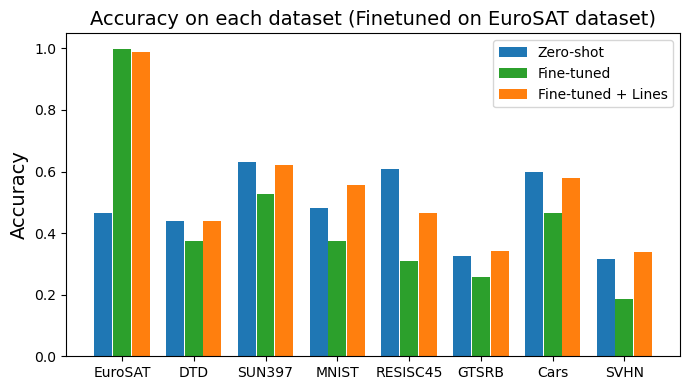

In [ ]:
# plot for each method: zeroshot, ft, lines, a bar plot for the accuracies on each dataset
import matplotlib.pyplot as plt

datasets = all_datasets
zeroshot_accuracies_list = [zeroshot_accuracies[dataset]['top1'] for dataset in datasets]
ft_accuracies_list = [ft_accuracies[dataset]['top1'] for dataset in datasets]
lines_accuracies_list = [lines_accuracies[dataset]['top1'] for dataset in datasets]

x = np.arange(len(datasets))
width = 0.25

fig, ax = plt.subplots(figsize=(7, 4))
rects1 = ax.bar(x - width - 0.01, zeroshot_accuracies_list, width, label='Zero-shot', color='tab:blue')
rects2 = ax.bar(x, ft_accuracies_list, width, label='Fine-tuned', color='tab:green')
rects3 = ax.bar(x + width+0.01, lines_accuracies_list, width, label='Fine-tuned + Lines', color='tab:orange')

ax.set_ylabel('Accuracy', fontsize=14)
ax.set_title(f'Accuracy on each dataset (Finetuned on {target_dataset} dataset)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(datasets)

# show the legend with rects1, re
ax.legend()

fig.tight_layout()
plt.show()

Averaged the accuracy for control tasks:

In [ ]:
# plot for each method: zeroshot, ft, lines, a bar plot for the accuracies on each dataset
import matplotlib.pyplot as plt

datasets = all_datasets
zeroshot_accuracies_avg = [zeroshot_accuracies_list[0], np.mean(zeroshot_accuracies_list[1:])]
ft_accuracies_avg = [ft_accuracies_list[0], np.mean(ft_accuracies_list[1:])]
lines_accuracies_avg = [lines_accuracies_list[0], np.mean(lines_accuracies_list[1:])]

zeroshot_accuracies_control_std = np.std(zeroshot_accuracies_list[1:])
ft_accuracies_control_std = np.std(ft_accuracies_list[1:])
lines_accuracies_control_std = np.std(lines_accuracies_list[1:])

x = np.arange(2)
width = 0.15

fig, ax = plt.subplots(figsize=(6, 3.8))
rects1 = ax.bar(x - width - 0.01, zeroshot_accuracies_avg, width, label='Zero-shot', color='tab:blue')
rects2 = ax.bar(x, ft_accuracies_avg, width, label='Fine-tuned', color='tab:green')
rects3 = ax.bar(x + width+0.01, lines_accuracies_avg, width, label='Fine-tuned + Lines', color='tab:orange')

# plot the error bars for control datasets
ax.errorbar(x[1] - width - 0.01, zeroshot_accuracies_avg[1], yerr=zeroshot_accuracies_control_std, fmt='none', ecolor='black', capsize=3)
ax.errorbar(x[1], ft_accuracies_avg[1], yerr=ft_accuracies_control_std, fmt='none', ecolor='black', capsize=3)
ax.errorbar(x[1] + width + 0.01, lines_accuracies_avg[1], yerr=lines_accuracies_control_std, fmt='none', ecolor='black', capsize=3)

ax.set_ylabel('Accuracy', fontsize=14)
ax.set_title(f'Accuracy on each dataset (Finetuned on {target_dataset} dataset)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(['Target task', 'Control tasks'])

ax.legend()

fig.tight_layout()
plt.show()

NameError: name 'all_datasets' is not defined